In [49]:
import pandas as pd
import spacy
import contextualSpellCheck
import re
import pickle
import math
from readability import Readability, exceptions
from spacy_syllables import SpacySyllables

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('syllables', after='tagger', config={"lang": "en_US"})

contextualSpellCheck.add_to_pipe(nlp)
data_set = pd.read_csv('../data/blogtext.csv')

In [20]:

print(data_set.groupby('topic')['id'].count())

topic
Accounting                   3832
Advertising                  4676
Agriculture                  1235
Architecture                 1638
Arts                        32449
Automotive                   1244
Banking                      4049
Biotech                      2234
BusinessServices             4500
Chemicals                    3928
Communications-Media        20140
Construction                 1093
Consulting                   5862
Education                   29633
Engineering                 11653
Environment                   592
Fashion                      4851
Government                   6907
HumanResources               3010
Internet                    16006
InvestmentBanking            1292
Law                          9040
LawEnforcement-Security      1878
Manufacturing                2272
Maritime                      280
Marketing                    4769
Military                     3128
Museums-Libraries            3096
Non-Profit                  14700
Publishi

In [30]:
data_bio = data_set[data_set['topic']=='Biotech']
data = data_bio[['id', 'text', 'date']]
df = data[data.groupby('id')['id'].transform('size') > 50]
print(len(df.groupby('id')))


10


In [62]:
def get_trigram_features(pos_string):
    # Trigrams list
    # NVN NNV VNN NADPPROPN NNCCONJ NOUNPREPDET DETNOUNPREP VNV NNN  NOUNPREPNOUN VPREPDET
    features = {}
    features['nvn'] = len(re.findall('(NOUN VERB NOUN)', pos_string))
    features['nnv'] = len(re.findall('(NOUN NOUN VERB)', pos_string))
    features['vnn'] = len(re.findall('(VERB NOUN NOUN)', pos_string))
    features['vnv'] = len(re.findall('(VERB NOUN VERB)', pos_string))
    features['nap'] = len(re.findall('(NOUN ADP PROPN)', pos_string))
    features['nnc'] = len(re.findall('(NOUN NOUN CCONJ)', pos_string))
    features['nad'] = len(re.findall('(NOUN ADP DET)', pos_string))
    features['dna'] = len(re.findall('(DET NOUN ADP)', pos_string))
    features['nnn'] = len(re.findall('(NOUN NOUN NOUN)', pos_string))
    features['nan'] = len(re.findall('(NOUN ADP NOUN)', pos_string))
    features['vad'] = len(re.findall('(VERB ADP DET)', pos_string))
    
    return features 

def rank_words(word_freq):
    freq_sorted = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    prev = max(freq_sorted.values())
    rank = 1
    ranks = {}
    for word, freq in freq_sorted.items():
        if freq < prev:
            rank += 1
            prev = freq
        ranks[word] = rank
    return ranks

def get_average_word_rank(word_freq):
    ranks = rank_words(word_freq) 
    return sum(list(ranks.values()))/len(ranks)

def get_lemma_freq(lemma, word_freq):
    if lemma in word_freq.keys():
        return word_freq[lemma]
    else:
        return 0

closed_class = ['ADP','AUX','CCONJ','DET','NUM','PART','PRON','SCONJ']

def get_yule_score(freq_dict):
    m1 = sum(freq_dict.values())
    m2 = sum([freq ** 2 for freq in freq_dict.values()])
    if m2 > m1:
        i = (m1*m1) / (m2-m1)
    else:
        i = -1
    k = 10000/i
    return k


def get_honore(freq_dict, text_len):
    hapax_legomena = list(freq_dict.values()).count(1)
    if hapax_legomena == len(freq_dict):
        return 0
    return 100 * math.log(text_len)/(1-(hapax_legomena/len(freq_dict)))


def get_features(df):
    
    id_tags = df['id'].unique()
    ids = id_tags[:10]
    all_features = pd.DataFrame(columns=['id','yule', 'fk_grade', 'f_reading', 'gunning_fog', 'honore_r', 'avg_word_length', 'syllable_no', 'spelling_errors', 'no_tag', 'sym', 'punct', 'mean_word_rank', 'of_freq', 'is_freq', 'the_freq', 'been_freq','nvn','nnv','vnn','vnv','nap','nnc','nad','dna','nnn','nan','vad'])
    i = 0
    for id in ids:
        features_author = []
        for text in df.loc[df['id']==id, 'text']:
            
            if i % 50 == 0:
                print("Computed features of {} of texts".format(i/len(df['text'])))
            i += 1
            
            if len(text) > 1000000:
                print("Text too long. Skipped.")
                continue
            try:
                tokenized = nlp(text)
            except RuntimeError:
                print("Runtime")
                continue
    
            pos_only = []
            word_freq = {}
            word_length = 0
            syllable_no = 0
            word_count = 0
            
            for token in tokenized:
                if not token.text.isspace():
                    pos_only.append(token.pos_)
                    if token.pos_ not in ['X', 'SYM', 'PUNCT']:
                        word_length += len(token.text)
                        if token._.syllables_count:
                            syllable_no += token._.syllables_count
                        word_count += 1
                    # print(token.lemma_, token.pos_, token.tag_)
                    if token.lemma_ not in word_freq.keys():
                        word_freq[token.lemma_] = 1
                    else:
                        word_freq[token.lemma_] += 1
                        
            if len(pos_only) < 1 or word_count < 1:
                continue
                    
            features = get_trigram_features(' '.join(pos_only))
            
            features['id']=id
            features['spelling_errors'] = len(tokenized._.suggestions_spellCheck)
            features['no_tag'] = pos_only.count('X')
            features['sym'] = pos_only.count('SYM')
            features['punct'] = pos_only.count('PUNCT')
            freq_sorted = dict(sorted(word_freq.items(), key=lambda item: item[1]))
            
            features['yule'] = get_yule_score(freq_sorted)
            
            
            try:
                r = Readability(text)
                features['fk_grade'] = r.flesch_kincaid().grade_level
                features['f_reading'] = r.flesch().ease
                features['gunning_fog'] = r.gunning_fog().score
            except:
                features['fk_grade'] = 0
                features['f_reading'] = 0
                features['gunning_fog'] = 0
                
            
            features['honore_r'] = get_honore(freq_sorted, len(pos_only))
            
            features['mean_word_rank'] = get_average_word_rank(freq_sorted)
            features['of_freq'] = get_lemma_freq('of', freq_sorted)
            features['is_freq'] = get_lemma_freq('is', freq_sorted)
            features['the_freq'] = get_lemma_freq('the', freq_sorted)
            features['been_freq'] = get_lemma_freq('been', freq_sorted)

            features['avg_word_length'] = word_length/word_count
            features['sylablle_no'] = syllable_no/word_count
            
            features_author.append(features)
        
        features_df = pd.DataFrame(features_author)
        all_features = all_features.append(features_df, ignore_index=True)
        
    return all_features

In [63]:
features = get_features(df)
        
        

Computed features of 0.0 of texts
Computed features of 0.0324254215304799 of texts
Computed features of 0.0648508430609598 of texts
Computed features of 0.09727626459143969 of texts
Computed features of 0.1297016861219196 of texts
Computed features of 0.1621271076523995 of texts
Computed features of 0.19455252918287938 of texts
Runtime
Computed features of 0.22697795071335927 of texts
Computed features of 0.2594033722438392 of texts
Computed features of 0.2918287937743191 of texts
Computed features of 0.324254215304799 of texts
Computed features of 0.35667963683527887 of texts
Computed features of 0.38910505836575876 of texts
Computed features of 0.42153047989623865 of texts
Computed features of 0.45395590142671854 of texts
Computed features of 0.48638132295719844 of texts
Computed features of 0.5188067444876784 of texts
Computed features of 0.5512321660181583 of texts
Computed features of 0.5836575875486382 of texts
Computed features of 0.6160830090791181 of texts
Computed features of

In [68]:

with open('../output/features/features_biotech.pkl', 'wb') as file:
    pickle.dump(features, file)

In [36]:
text = "Well, I'll stand corrected, again. Yesterday I blogged that Coquitlam was an oasis of Whiteness in the sea of Asians that is Vancouver, but oh how I was wrong.  We went to the, aptly named, Coquitlam Mall today and put Spencer in the play area with a few other kids.  I heard a lady speaking Korean to her boy, then a flock (well, three) ajumas (older Korean ladies) came and sat near us.  Later, when we went to the pool, we saw that the neighbors right next to us and across the street are Koreans too.  Then on the way back I learned that another two sets of neighbors are Korean as well.  They\'re everywhere!  It\'s actually pretty cool.  One thing about Koreans is they have a pretty good sense of community.  Get a group of white people (who aren\'t farmers) together and we seem to be pretty stand-offish...or at least it takes a while to warm up.  Koreans, as you may know,  urlLink refer to each other as sister or brother  as soon as 3 minutes of meeting one another (as I have seen).  This is, I think, quite extraordinary.  From first meetings with my son my wife called the girls in the area \'nuna\' or \'older sister, as said by a  younger brother\' (they have a special word for every family member).  Also, since Koreans don\'t normally take to English all that well (or quickly) they really, really appreciate speaking with someone from home.  Thus, the community here is quite tight.  So I\'ve still got jetlag...although it\'s pretty nice not to have to work through it.  The boys tend to keep me moving all day, though.  Usually I sleep at 3AM or 4AM then get up at 11AM, but it\'s not a good  urlLink REM  sleep.  My best sleep seems to be 1-2 hour naps at 3PM or 7PM.  When I wake up from those it\'s really like getting up in the morning; and getting up in the morning is like waking up at midnight.  My father-in-law thinks I should just adjust 100% in like 2 days, but I\'m not sure if I\'m built that way.  If I need to I can do it, but it\'s like I\'m on vacation here.  Besides, I do my work at night anyways, when the kids are asleep (and Seoul is awake).  I guess that\'s it for now.  Nothing more profound than this from the day, which is a little sad.  I love it here: so clean, peaceful and easy to live; but I kinda miss Seoul too: so dirty, loud and easy to get run down by  urlLink deliveryboys on motorcycles."
for w in nlp(text):
    if not w.text.isspace() and w.pos_ not in ['X', 'SYM', 'PUNCT']:
        print(w._.syllables_count)
        print(w.pos_)


1
INTJ
1
PRON
None
AUX
1
VERB
3
VERB
1
ADV
3
NOUN
1
PRON
1
VERB
1
SCONJ
3
PROPN
1
AUX
1
DET
2
NOUN
1
ADP
2
PROPN
1
ADP
1
DET
1
NOUN
1
ADP
1
PROPN
1
DET
1
VERB
3
PROPN
1
CCONJ
1
INTJ
1
ADV
1
PRON
1
VERB
1
ADJ
1
PRON
1
VERB
1
ADP
1
DET
2
ADV
1
VERB
3
PROPN
1
PROPN
2
NOUN
1
CCONJ
1
VERB
1
PROPN
1
ADP
1
DET
1
NOUN
1
NOUN
1
ADP
1
DET
1
ADJ
2
ADJ
1
NOUN
1
PRON
1
VERB
1
DET
2
NOUN
2
VERB
3
PROPN
1
ADP
1
PRON
1
NOUN
1
ADV
1
DET
1
NOUN
1
INTJ
1
NUM
2
NOUN
2
ADJ
3
ADJ
1
NOUN
1
VERB
1
CCONJ
1
VERB
1
SCONJ
1
PRON
2
ADV
1
ADV
1
PRON
1
VERB
1
ADP
1
DET
1
NOUN
1
PRON
1
VERB
1
SCONJ
1
DET
2
NOUN
1
ADV
1
ADV
1
ADP
1
PRON
1
CCONJ
1
ADP
1
DET
1
NOUN
1
AUX
3
PROPN
1
ADV
1
ADV
1
ADP
1
DET
1
NOUN
1
ADV
1
PRON
1
VERB
1
SCONJ
3
DET
1
NUM
1
NOUN
1
ADP
2
NOUN
1
AUX
3
ADJ
1
ADV
1
ADV
1
PRON
None
VERB
3
ADV
1
PRON
None
AUX
4
ADV
2
ADV
1
ADJ
1
NUM
1
NOUN
1
ADP
3
PROPN
1
AUX
1
PRON
1
VERB
1
DET
2
ADV
1
ADJ
1
NOUN
1
ADP
4
NOUN
1
VERB
1
DET
1
NOUN
1
ADP
1
ADJ
2
NOUN
1
PRON
1
VERB
None
PART
2
NOUN
3
ADV
1
CCONJ
1
PRON

In [6]:

with open('features_syntactic_biotech.pkl', 'rb') as file:
    features = pickle.load(file)
features.groupby('id')['spelling_errors'].count()
two_authors = features.loc[features['id'].isin([691951, 2373875])]

EOFError: Ran out of input

Accuracy (RBF Kernel):  79.59
F1 (RBF Kernel):  79.39


Text(0.5, 0, 'Permutation Importance')

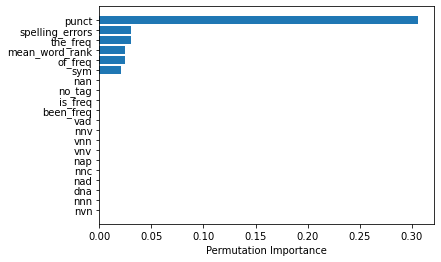

In [69]:
from sklearn import svm
import numpy as np
from sklearn.inspection import permutation_importance
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt

X = two_authors.drop(['id'], axis = 1).values.tolist()
y = two_authors['id'].tolist()
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20)


rbf = svm.SVC(kernel='rbf', C=2).fit(X_train, y_train)
perm_importance = permutation_importance(rbf, X_test, y_test)

rbf_pred = rbf.predict(X_test)
rbf_accuracy = accuracy_score(y_test, rbf_pred)
rbf_f1 = f1_score(y_test, rbf_pred, average='weighted')
print('Accuracy (RBF Kernel): ', "%.2f" % (rbf_accuracy*100))
print('F1 (RBF Kernel): ', "%.2f" % (rbf_f1*100))

feature_names = ['spelling_errors', 'no_tag', 'sym', 'punct', 'mean_word_rank', 'of_freq', 'is_freq', 'the_freq', 'been_freq','nvn','nnv','vnn','vnv','nap','nnc','nad','dna','nnn','nan','vad']
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [70]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return svm.SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return svm.SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return svm.SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return svm.SVC(kernel='linear', gamma="auto")

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.20)
for i in range(4):    
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

      691951       0.81      0.84      0.82        50
     2373875       0.83      0.79      0.81        48

    accuracy                           0.82        98
   macro avg       0.82      0.82      0.82        98
weighted avg       0.82      0.82      0.82        98

Evaluation: RBF kernel
              precision    recall  f1-score   support

      691951       0.65      0.79      0.71        42
     2373875       0.81      0.68      0.74        56

    accuracy                           0.72        98
   macro avg       0.73      0.73      0.72        98
weighted avg       0.74      0.72      0.73        98

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

      691951       0.23      0.31      0.27        42
     2373875       0.31      0.23      0.27        56

    accuracy                           0.27        98
   macro avg       0.27      0.27      0.27     

In [71]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(classification_report(y_test,grid_predictions))#Output



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   4.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   3.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   3.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   6.4s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, k